In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd

from pprint import pprint
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
!ls rsna-pneumonia-detection-challenge

GCP Credits Request Link - RSNA.txt stage_2_test_images
stage_2_detailed_class_info.csv     stage_2_train_images
stage_2_sample_submission.csv       stage_2_train_labels.csv


# Load pneumonia images, bounding boxs and detail infos

csv file -- stage_2_train_labels.csv
* If a patient got diagnoised with multiple pneumonia, rows of bounding boxs of different pneumonia locations with same patientId will appear.
* If a patient has no pneumonia, csv contains a single row with nan for bounding boxs.

csv file -- stage_2_detailed_class_info.csv

* patientId with the final diagnoised varies between Normal, Lung Opacity, and No Lung Opacity / Not Normal.

In [3]:
dir_dicom = os.path.join(os.getcwd(), 'rsna-pneumonia-detection-challenge')
dicoms_training = os.path.join(dir_dicom, 'stage_2_train_images')

In [4]:
df = pd.read_csv(os.path.join(dir_dicom, 'stage_2_train_labels.csv')).fillna(0)
df_detail = pd.read_csv(os.path.join(dir_dicom, 'stage_2_detailed_class_info.csv'))

In [5]:
df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0.0,0.0,0.0,0.0,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0.0,0.0,0.0,0.0,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [6]:
df_detail

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [7]:
df["patientId"].nunique()

26684

In [8]:
df.isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

### Patients got different numbers of pneumonia

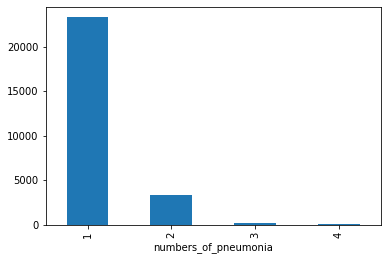

In [9]:
df.groupby("patientId").size().reset_index(name="numbers_of_pneumonia").groupby("numbers_of_pneumonia").size().plot.bar()

### Merge rows to one single row

In [10]:
columns = ['x', 'y', 'width', 'height']
df['bounding_boxs'] = df[columns].to_dict(orient='record')
df = df.drop(columns=columns)
df = df.groupby(["patientId", "Target"])["bounding_boxs"].apply(lambda df: df.reset_index(drop=True)).unstack().reset_index()

### append class of details of dataframe

In [11]:
_df = pd.merge(df, df_detail, on=['patientId', 'patientId'])
_df

,patientId,Target,0,1,2,3,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,"{'x': 316.0, 'y': 318.0, 'width': 170.0, 'heig...","{'x': 660.0, 'y': 375.0, 'width': 146.0, 'heig...",NaN,NaN,Lung Opacity
3,000db696-cf54-4385-b10b-6b16fbb3f985,1,"{'x': 316.0, 'y': 318.0, 'width': 170.0, 'heig...","{'x': 660.0, 'y': 375.0, 'width': 146.0, 'heig...",NaN,NaN,Lung Opacity
4,000fe35a-2649-43d4-b027-e67796d412e0,1,"{'x': 570.0, 'y': 282.0, 'width': 269.0, 'heig...","{'x': 83.0, 'y': 227.0, 'width': 296.0, 'heigh...",NaN,NaN,Lung Opacity
...,...,...,...,...,...,...,...
30222,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,"{'x': 177.0, 'y': 285.0, 'width': 225.0, 'heig...","{'x': 641.0, 'y': 473.0, 'width': 201.0, 'heig...",NaN,NaN,Lung Opacity
30223,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
30224,fffc95b5-605b-4226-80ab-62caec682b22,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
30225,fffcff11-d018-4414-971a-a7cefa327795,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal


In [23]:
def print_bounding_box(dicom):
    """plot rectangle boxs for a single dicom image
    params: patientId and bounding boxs       
    """
    _dicom_img = pydicom.dcmread(os.path.join(dicoms_training, dicom.patientId + '.dcm'))
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(_dicom_img.pixel_array, cmap=plt.cm.bone)#cmap stands for color map

    for bb in (dicom[0], dicom[1], dicom[2], dicom[3]):
        if isinstance(bb, dict) and bb["x"] != "nan":
            x = bb["x"]
            y = bb["y"]
            w = bb["width"]
            h = bb["height"] 
            # Create a Rectangle patch
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

    ax.set_title('ID: {}\nAge: {} Sex: {} Target: {}\nClass: {}'.format(
        dicom.patientId,
        _dicom_img.PatientAge, 
        _dicom_img.PatientSex, 
        dicom['Target'], 
        dicom['class']))
    plt.show()

In [13]:
def print_samples(df, nc = 1):
    count = 0
    for index, row in df.iterrows():
        print_bounding_box(row)
        count +=1
        
        if count >= nc:
            break

## Get some samples of bb(bounding boxs) of 1, 2, 3, 4

In [14]:
df_4 = _df[_df[3].notna()]
df_3 = _df[_df[2].notna()]
df_2 = _df[_df[1].notna()]
df_1 = _df[_df[0].notna()]
df_0 = _df[_df[0] == dict(x=0, y=0, width=0, height=0)]

df_3 = df_3[~df_3.patientId.isin(df_4.patientId)]
df_2 = df_2[~df_2.patientId.isin(df_3.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_2.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_0.patientId)]

# Photometric Interpretation          CS: 'MONOCHROME2',
# Rows                                US: 1024,
# Columns                             US: 1024,

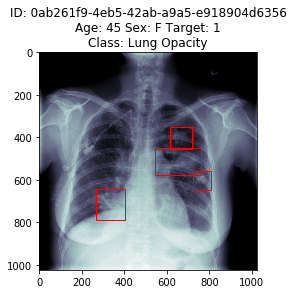

In [24]:
print_samples(df_4)

Patient id.......: 02b7b018-0fed-44c2-a9c2-93b2b3952efc


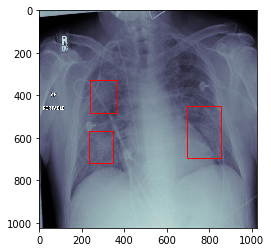

In [16]:
print_samples(df_3)

Patient id.......: 000db696-cf54-4385-b10b-6b16fbb3f985


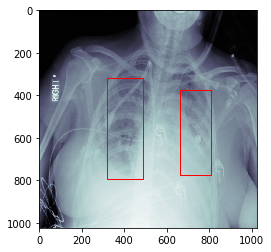

In [17]:
print_samples(df_2)

Patient id.......: 001916b8-3d30-4935-a5d1-8eaddb1646cd


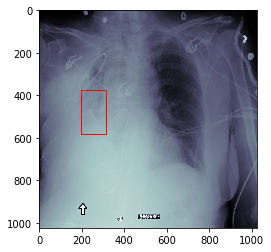

In [18]:
print_samples(df_1)

26684 patients


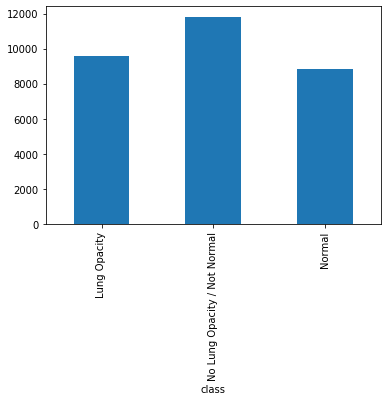

In [19]:
print(_df['patientId'].value_counts().shape[0], 'patients')
_df.groupby('class').size().plot.bar()

#### It clearly shows patients with lung opacity is our target

In [22]:
_df.groupby(["class", "Target"]).size()

class                         Target
Lung Opacity                  1          9555
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64